## Importing the Libraries

In [32]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings

## Loading and Exploring the Dataset

#### 1. Loading the Dataset

In [33]:
try:
    df = pd.read_csv("Online Retail.csv", encoding='latin1')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'Online Retail.csv' was not found.")
    exit()

Data loaded successfully.


#### 2. Exploring the Dataset

In [34]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [35]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [36]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


The negative values of minimum for Quantity and UnitPrice is due to the presence of orders that were cancelled.

## Data Cleaning and Preprocessing

To prepare the data for customer segmentation, specific steps are taken to handle incomplete or irrelevant records. First, rows where the `CustomerID` is missing are dropped, as customer identification is essential for the analysis. Without a unique ID, customers cannot be segmented, making these records unusable for the intended purpose.

Second, any cancelled orders are removed from the dataset. These are identified by an `InvoiceNo` that contains the letter 'C'. In a retail context, an invoice number containing 'C' often signifies a credit note or a cancelled order. Also, from the descriptive statistics (count, mean, std, min, max, and quartiles), it is observed that the minimum values for `Quantity` and `UnitPrice` are negative, which is a direct consequence of the cancelled orders. Removing these records prevents the analysis of customer frequency and monetary value from being skewed by invalid purchases.

Third, the `InvoiceDate` column is converted to a datetime data type to enable time-based calculations, such as determining the "Recency" of a customer's most recent purchase.

In [37]:
df.dropna(subset=['CustomerID'], inplace=True)
df = df[~df['InvoiceNo'].str.contains('C', na=False)]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

The **`InvoiceDay`** column is added to the data so that each invoice's date can be analyzed on a daily basis. This is done to enable versatile time-based analyses, as the data can then be analyzed by individual days or grouped into different daily intervals.

In [38]:
df['InvoiceDay'] = df['InvoiceDate'].apply(lambda x: dt.datetime(x.year, x.month, x.day))

A new variable, `TotalPrice`, is created to represent the total cost of each product. This is calculated by multiplying the quantity of each item by its unit price. Based on this, the total expenses for each customer can then be computed and used for financial analysis.

In [39]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [40]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34


In [41]:
df.shape

(397924, 10)

In [42]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
InvoiceDay     0
TotalPrice     0
dtype: int64

## Feature Engineering: Building the RFM Model

The RFM model is constructed to summarize customer purchasing behavior into three core metrics: **Recency**, **Frequency**, and **Monetary** value. These metrics are used as features for a clustering algorithm.
- **Recency** is a measure of how recently a customer's last purchase was made. A lower value indicates a more recent purchase, which is considered a better score.
- **Frequency** is the measure of how often purchases are made by a customer. A higher value for this metric is considered more favorable.
- **Monetary** value represents the total amount of money a customer has spent. A higher value is preferred, as it signifies a greater financial contribution.

Here:
* A **snapshot date** is created by adding one day to the most recent invoice date. This serves as the reference point for calculating recency.
* The data is **grouped by `CustomerID`** to perform calculations for each individual customer.
* **Recency** is calculated by finding the difference in days between the snapshot date and the customer's last purchase date.
* **Frequency** is determined by counting the number of unique invoices for each customer.
* **Monetary** value is calculated by summing the total price of all purchases for each customer.
* The columns are **renamed** to 'Recency', 'Frequency', and 'Monetary' for clarity.
* Finally, the `CustomerID` is **reset from the index** to become a regular column in the new `rfm_df` DataFrame.

In [43]:
snapshot_date = df['InvoiceDay'].max() + dt.timedelta(days=1)
rfm_df = df.groupby('CustomerID').agg({
    'InvoiceDay': lambda date: (snapshot_date - date.max()).days,
    'InvoiceNo': lambda num: len(num.unique()),
    'TotalPrice': lambda price: price.sum()
})
rfm_df.columns = ['Recency', 'Frequency', 'Monetary']
rfm_df = rfm_df.reset_index()

In [44]:
rfm_df.shape

(4339, 4)

In [45]:
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,3,7,4310.00
2,12348.0,76,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,311,1,334.40


## Preparing Data for Clustering

The data is prepared for clustering, as K-means is a distance-based algorithm. If features have different scales, the algorithm becomes biased toward features with larger values.
- **Log Transformation:** The Recency, Frequency, and Monetary values are often highly skewed. A natural logarithm is applied to the data to normalize this distribution, making it more Gaussian-like and suitable for the clustering algorithm. The value 1 is added to all values before the transformation to avoid issues with $\ln(0)$.
- **Scaling:** The data is scaled to have a mean of 0 and a standard deviation of 1 using `StandardScaler`. This is done to ensure that all three RFM features contribute equally to the distance calculations, which prevents features with a larger magnitude from dominating the clustering process.

In [46]:
rfm_df = rfm_df[rfm_df['Monetary'] > 0]
rfm_log = np.log(rfm_df[['Recency', 'Frequency', 'Monetary']] + 1)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

In [47]:
rfm_scaled_df.shape

(4338, 3)

In [48]:
rfm_scaled_df.head()

,Recency,Frequency,Monetary
0,1.478884,-0.955224,3.706225
1,-1.890642,1.074292,1.411843
2,0.372339,0.386213,0.716489
3,-0.659158,-0.955224,0.698739
4,1.442954,-0.955224,-0.618962


## K-means Clsutering

The **Elbow Method** is used to determine the optimal number of clusters, known as *k*. The core idea is to identify the point where the **WCSS** (within-cluster sum of squares), which is the sum of the squared distances of samples to their nearest cluster center, begins to decrease at a slower rate. This "elbow" point is chosen as it represents a good trade-off between the number of clusters and the model's performance.

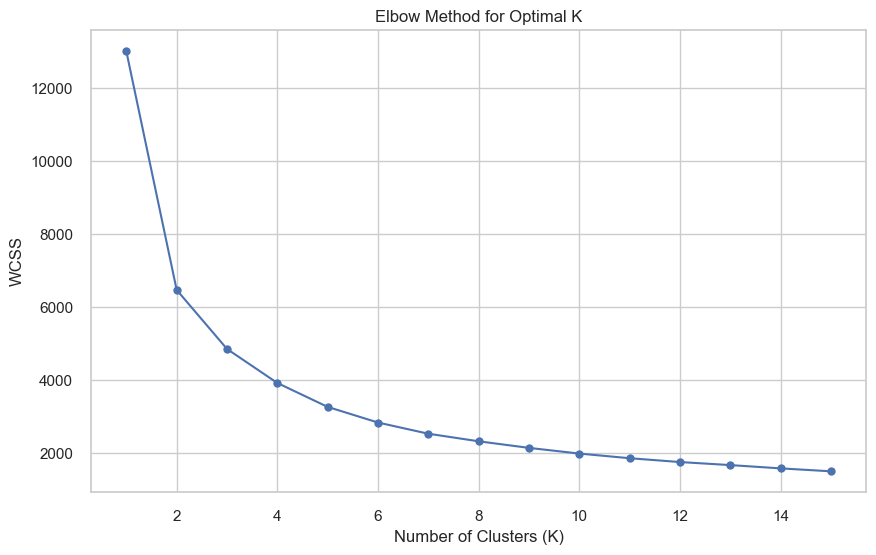

In [49]:
WCSS = []
for k in range(1, 16):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled_df)
    WCSS.append(kmeans.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 16), WCSS, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

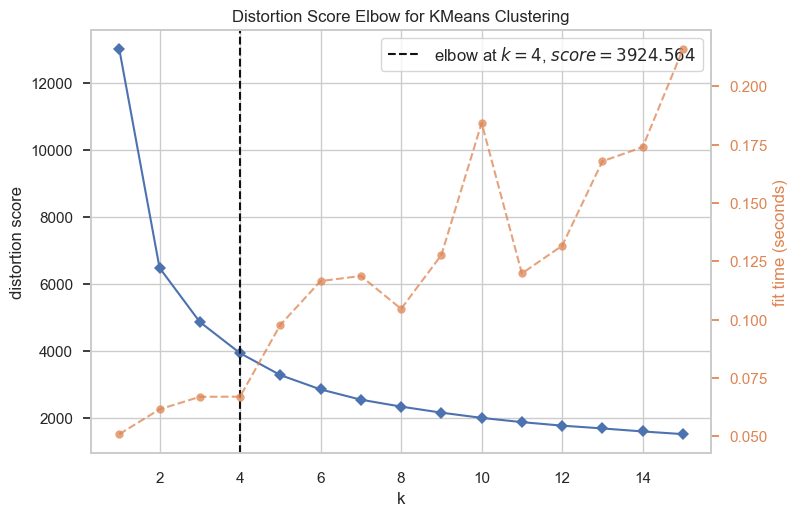

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [50]:
# Using Yellowbrick for automated elbow point detection
from yellowbrick.cluster import KElbowVisualizer
km = KMeans(random_state=42, n_init=10)
visualizer = KElbowVisualizer(km, k=(1,16))
visualizer.fit(rfm_scaled_df)
visualizer.show()

Based on the above plot, using the **Elbow Method** the optimal number of clusters, *k*, can be considered as `4`, as the WCSS begins to decrease at a slower rate after this number of clusters.

In [69]:
optimal_k = 4
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm_df['Cluster'] = kmeans_model.fit_predict(rfm_scaled_df)

In [70]:
rfm_df.shape

(4338, 5)

In [71]:
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,326,1,77183.60,3
1,12347.0,3,7,4310.00,2
2,12348.0,76,4,1797.24,3
3,12349.0,19,1,1757.55,0
4,12350.0,311,1,334.40,1


## Analyzing and Visualizing the Clsuters

After clustering, each cluster is analyzed to understand its characteristics. The mean RFM values are calculated for each cluster to identify and name the customer segments.

A scatter plot is then used to visualize the separation of these segments. This visualization helps in understanding how the clusters are distinguished from each other based on their Recency and Monetary values.

Cluster sizes:
Cluster
1    1582
3    1161
0     875
2     720
Name: count, dtype: int64

Cluster Analysis (Mean, Median, and Standard Deviation for RFM values):
        Recency                            Frequency                     \
            min  max    mean median    std       min  max   mean median   
Cluster                                                                   
0             1   61   20.53   19.0  13.22         1    7   2.04    2.0   
1            31  374  187.70  183.0  99.07         1    6   1.33    1.0   
2             1  373   12.51    9.0  17.98         2  210  13.66   10.0   
3             8  367   68.71   54.0  53.70         1   14   4.14    4.0   

               Monetary                                               
           std      min        max     mean   median       std count  
Cluster                                                               
0         1.04    30.00    3861.00   526.00   449.45    358.97   875  
1         0.62     3.75    2

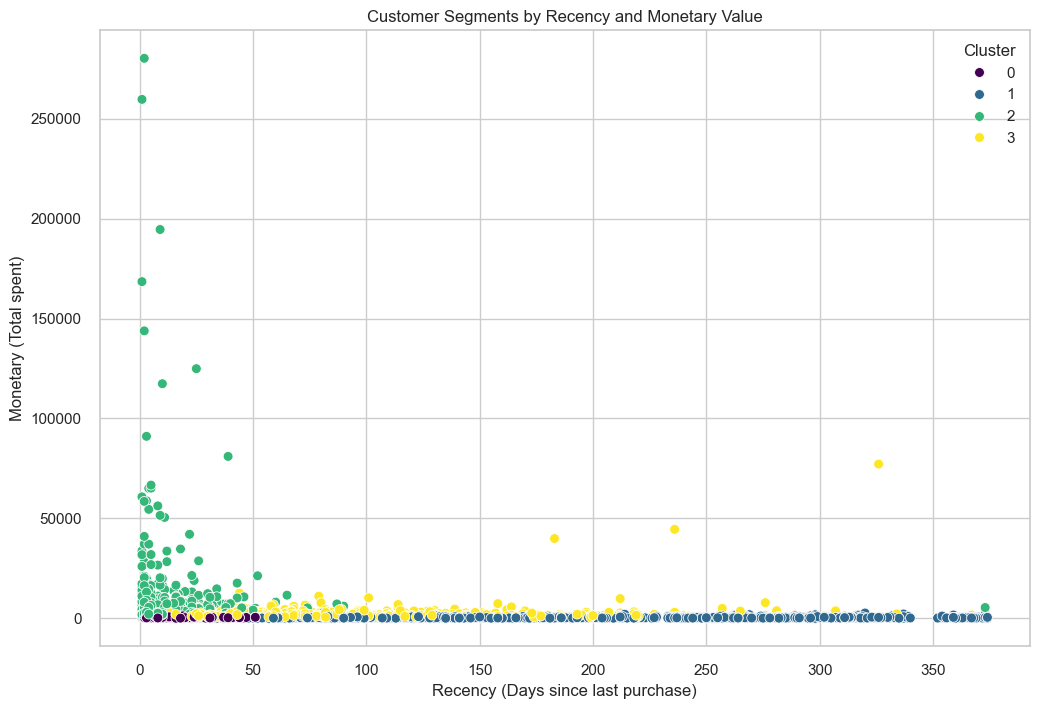

In [72]:
print(f"Cluster sizes:\n{rfm_df['Cluster'].value_counts()}")
cluster_analysis = rfm_df.groupby('Cluster').agg({
    'Recency': ['min', 'max', 'mean', 'median', 'std'],
    'Frequency': ['min', 'max', 'mean', 'median', 'std'],
    'Monetary': ['min', 'max', 'mean', 'median', 'std', 'count']
}).round(2)
print("\nCluster Analysis (Mean, Median, and Standard Deviation for RFM values):")
print(cluster_analysis)

plt.figure(figsize=(12, 8))
sns.scatterplot(data=rfm_df, x='Recency', y='Monetary', hue='Cluster', palette='viridis', s=50)
plt.title('Customer Segments by Recency and Monetary Value')
plt.xlabel('Recency (Days since last purchase)')
plt.ylabel('Monetary (Total spent)')
plt.grid(True)
plt.show()

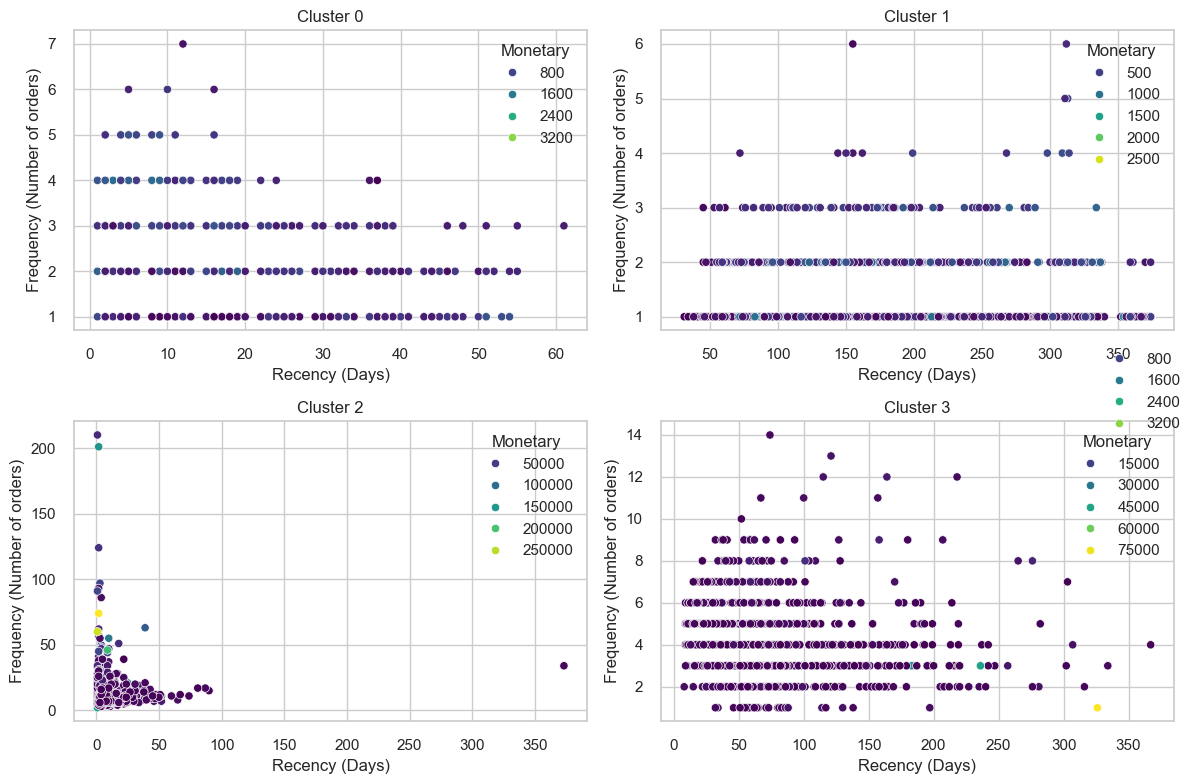

In [74]:
# Number of clusters
num_clusters = 4

# Create subplots with two clusters in each row
fig, axes = plt.subplots(num_clusters // 2, 2, figsize=(12, 8))

# Flatten the axes array to iterate through subplots
axes = axes.ravel()

# Loop through each cluster and plot it
for cluster_id in range(num_clusters):
    # Filter data for the current cluster
    cluster_data = rfm_df[rfm_df['Cluster'] == cluster_id]
    
    # Plot the data with a distinct color
    sns.scatterplot(data=cluster_data, x='Recency', y='Frequency', hue='Monetary', palette='viridis', ax=axes[cluster_id])
    
    # Set the title for the subplot
    axes[cluster_id].set_title(f'Cluster {cluster_id}')
    
    # Customize axes labels, if needed
    axes[cluster_id].set_xlabel('Recency (Days)')
    axes[cluster_id].set_ylabel('Frequency (Number of orders)')

# Add a common legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')

# Adjust subplot spacing
plt.tight_layout()

# Show the plot
plt.show()

Cluster Profiles (Mean and Median):
        Recency        Frequency        Monetary         
           mean median      mean median     mean   median
Cluster                                                  
0         20.53   19.0      2.04    2.0   526.00   449.45
1        187.70  183.0      1.33    1.0   353.59   300.68
2         12.51    9.0     13.66   10.0  8037.21  3726.08
3         68.71   54.0      4.14    4.0  1813.08  1353.74


C:\Users\Admin\AppData\Local\Temp\ipykernel_15760\2013466969.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Recency', data=rfm_df, palette='viridis', ax=axes[0])
C:\Users\Admin\AppData\Local\Temp\ipykernel_15760\2013466969.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Frequency', data=rfm_df, palette='viridis', ax=axes[1])
C:\Users\Admin\AppData\Local\Temp\ipykernel_15760\2013466969.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Monetary', data=rfm_df, palette='viridis', ax=a

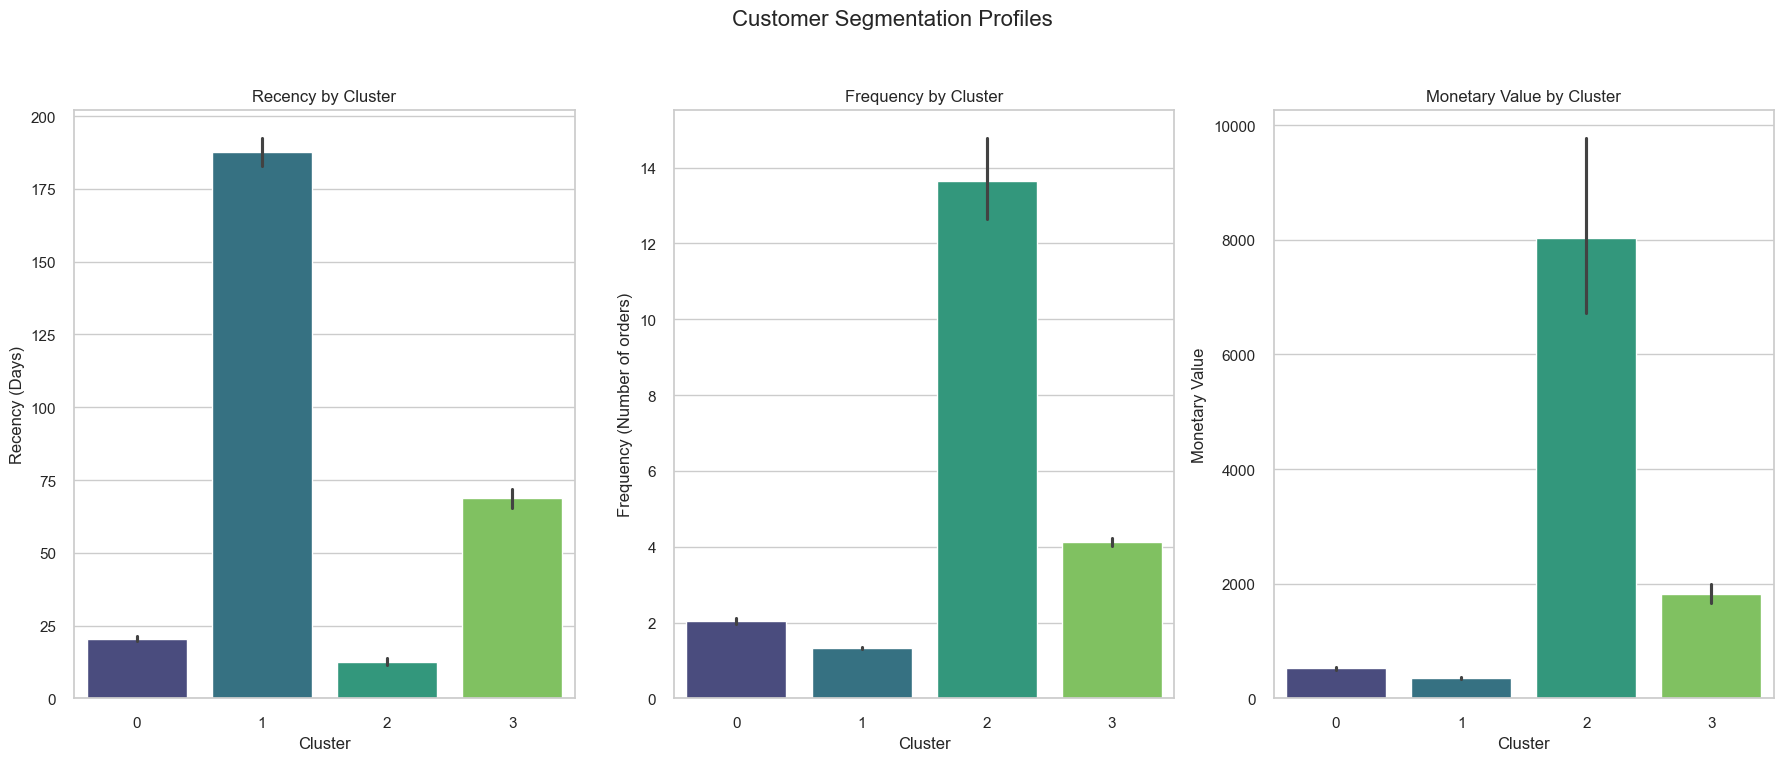

In [75]:
cluster_profile = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].agg(['mean', 'median']).round(2)
print("Cluster Profiles (Mean and Median):")
print(cluster_profile)

# Set style for the plots
sns.set(style="whitegrid")

# Create a figure with subplots for each feature
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
fig.suptitle('Customer Segmentation Profiles', fontsize=16)

# Bar chart for Recency
sns.barplot(x='Cluster', y='Recency', data=rfm_df, palette='viridis', ax=axes[0])
axes[0].set_title('Recency by Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Recency (Days)')

# Bar chart for Frequency
sns.barplot(x='Cluster', y='Frequency', data=rfm_df, palette='viridis', ax=axes[1])
axes[1].set_title('Frequency by Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Frequency (Number of orders)')

# Bar chart for Monetary
sns.barplot(x='Cluster', y='Monetary', data=rfm_df, palette='viridis', ax=axes[2])
axes[2].set_title('Monetary Value by Cluster')
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Monetary Value')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

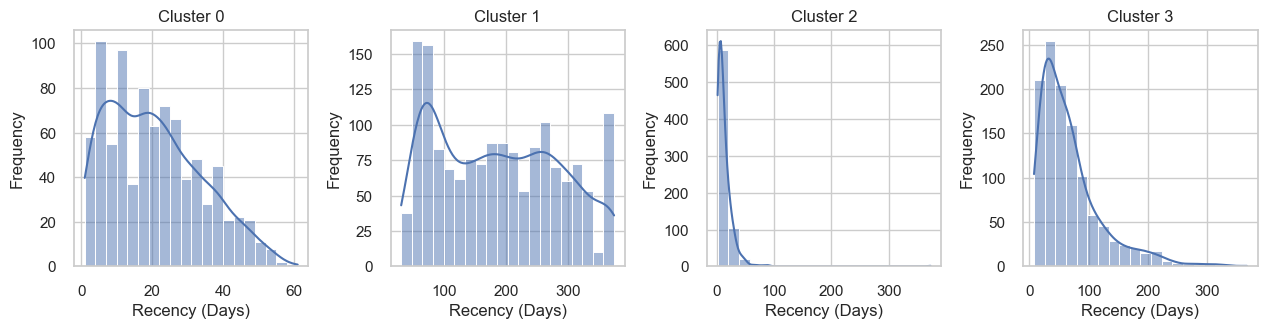

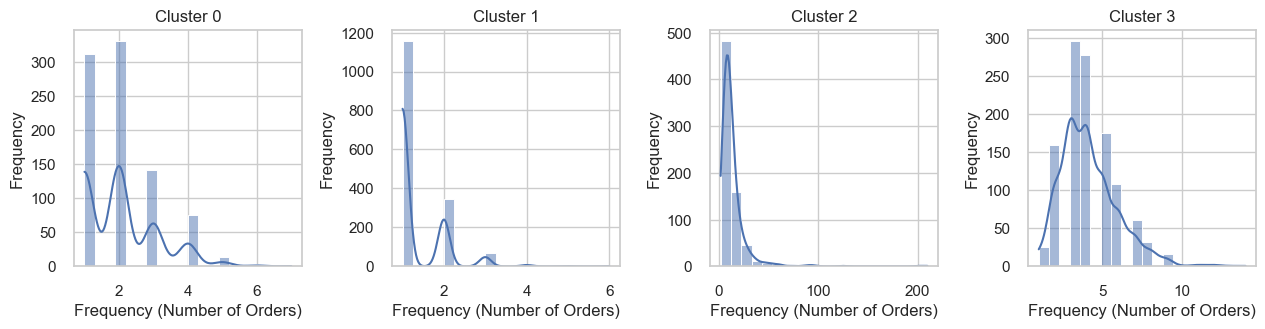

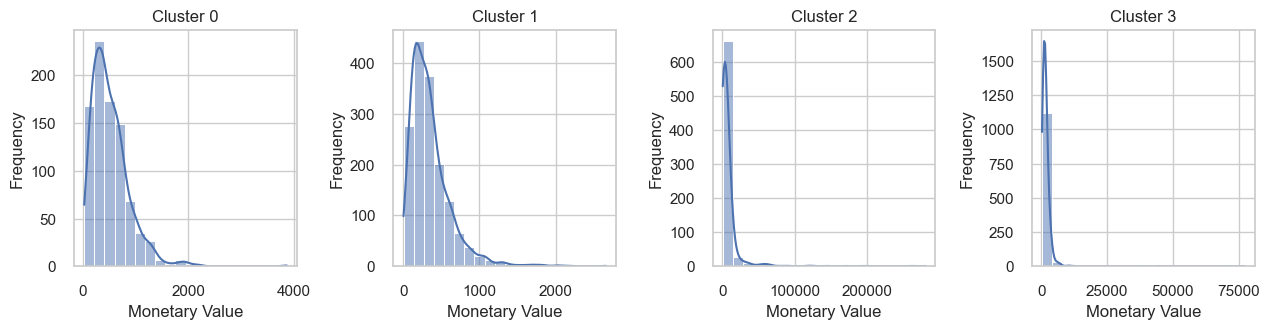

In [64]:
# Create a histogram for Recency in each cluster
plt.figure(figsize=(16, 6))
for cluster_id in range(num_clusters):
    plt.subplot(2, 5, cluster_id + 1)
    sns.histplot(rfm_df[rfm_df['Cluster'] == cluster_id]['Recency'], bins=20, kde=True)
    plt.title(f'Cluster {cluster_id}')
    plt.xlabel('Recency (Days)')
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show()

# Create a histogram for Frequency in each cluster
plt.figure(figsize=(16, 6))
for cluster_id in range(num_clusters):
    plt.subplot(2, 5, cluster_id + 1)
    sns.histplot(rfm_df[rfm_df['Cluster'] == cluster_id]['Frequency'], bins=20, kde=True)
    plt.title(f'Cluster {cluster_id}')
    plt.xlabel('Frequency (Number of Orders)')
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show()

# Create a histogram for Monetary in each cluster
plt.figure(figsize=(16, 6))
for cluster_id in range(num_clusters):
    plt.subplot(2, 5, cluster_id + 1)
    sns.histplot(rfm_df[rfm_df['Cluster'] == cluster_id]['Monetary'], bins=20, kde=True)
    plt.title(f'Cluster {cluster_id}')
    plt.xlabel('Monetary Value')
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show()